# Belchatow Case - Clean Startup

#### Packages

In [1]:
import json
from math import pi, ceil, sin, floor
from scipy.optimize import root
import numpy as np
import os.path
import sys
sys.path.append("../")
import simulate
from scipy.optimize import curve_fit

from water_properties import density, viscosity, conductivity, heat_capacity
from water_at_saturation_properties import saturation_temperature, vapour_density, vapour_total_compressibility,vaporization_enthalpy

from simplified_simulation import *

## Inputs e parameters

In [2]:
filename = "belchatow"
suffix = "cs" #clean startup

#### Constants

In [3]:
g = 9.80665 # m/s2 - gravitational acceleration
pi = pi # pi

#### Water Inlet

In [4]:
m = 2448 # kg/s cooling Water
Tin = 22.4 + 273.15 # K
Pin = 200000 # Pa

#### Pipe Information

In [5]:
v_pipe = 5.0 # m/s
L_pipe = 50 # m
water_density=density(Tin, Pin, simplified = True)
water_viscosity = viscosity(Tin, Pin, simplified = True)
D_pipe = 2 * (m / (pi * water_density * v_pipe )) ** 0.5
print("Pipe diameter is {} m ".format(D_pipe))
print("Pipe lenght is {} m ".format(L_pipe))

Pipe diameter is 0.790516585330527 m 
Pipe lenght is 50 m 


#### Heat Exchanger Information

In [6]:
Do = 0.024 # m external diameter
Di = Do - 2*0.001 # m external diameter
n_tubes = 3220
arrange = "triangle"
#arrange = "square"

L = 9.94 # m tube length
W = 1.8 # m bundle width
ep = 5e-6 # m - roughness
kwall = 16 # W / ( m * K )
pitch = 0.0333 # m
Rows = 15
row_pitch = pitch
tubes_per_width = n_tubes/Rows

ResF= 0 # K/W
ResF_to_film= 0 # K/W ###############CLEAN

Vext = L * W ** 2 # shell volume in m3

print("Number of tubes per row are ", tubes_per_width)
print("Number of rows is {number:.{digits}f}".format(number=Rows,digits=0))
print("Number of tubes is {number:.{digits}f}".format(number=Rows*tubes_per_width,digits=0))

Number of tubes per row are  214.66666666666666
Number of rows is 15
Number of tubes is 3220


In [7]:
N_wetters = []
row_index = np.linspace(1,Rows,num=Rows)
for i in row_index:
    if arrange == "triangle":
        N_wetters.append(ceil(i/2)-1)
    else:
        N_wetters = row_index-1
N_wetters = np.array(N_wetters)
fNtub = ((N_wetters+1) ** (5/6) - N_wetters ** (5/6))

In [8]:
# Fouling
Alc=300
pH=10.5
Ca=49.42

kf = 2.19 # W / ( m * K ) (Calcium carbonate)
rhof = 2.71e3 # kg/m3

mf = 0.001

Df = (Di ** 2 - 4 * mf * Di / rhof) ** 0.5

lf = 1e6*(Di-Df)/2  # um fouling thickness

Rf = Di * np.log(Di / Df ) / (2 * kf)

print("Wall internal diameter is {number:.{digits}f}".format(number=Di,digits=4))
print("Fouling internal diameter is {number:.{digits}f}".format(number=Df,digits=6))
print("Fouling thickness is {number:.{digits}f} um".format(number=1e6*(Di-Df)/2,digits=2))
print("Fouling deposit mass is {number:.{digits}f} kg/m2".format(number=mf,digits=6))
print("Rf is {number:.{digits}f} ".format(number=Rf,digits=6))


Wall internal diameter is 0.0220
Fouling internal diameter is 0.021999
Fouling thickness is 0.37 um
Fouling deposit mass is 0.001000 kg/m2
Rf is 0.000000 


#### Operational Conditions

In [9]:
# Expected
Tout_mean_expected = 30.2 + 273.15
Pvap_expected = 6615# Pa
Tvap_expected = 37.96 + 273.15
Pout_expected = 177000
Pout = 177000 # Pa
Tout = Tout_mean_expected * np.ones(Rows) # K
kvap_expected=33.13

In [10]:
Tm_expected = 0.5 * (Tin + Tout_mean_expected) # K - mean cooling water temperature
Pm_expected = 0.5 * (Pin + Pout) # Pa - mean cooling water pressure
water_heat_capacity = heat_capacity(Tm_expected, Pm_expected, simplified = True)

exhaust_steam_density = vapour_density(Pvap_expected, simplified = True)
exhaust_vaporization_heat = vaporization_enthalpy(Pvap_expected, simplified = True)

Q_expected = water_heat_capacity * m * (Tout_mean_expected - Tin)
kvap_expected = Q_expected/exhaust_vaporization_heat


print("Expected heat duty to {number:.{digits}f} MW.".format(number=Q_expected*1e-6, digits=2))
print("Expected steam mass flowrate {number:.{digits}f} kg/s.".format(number=kvap_expected, digits=2))
print("The exhaust steam density is equal to {number:.{digits}f} kg/m3."\
      .format(number=exhaust_steam_density, digits=5))
print("The exhaust steam vaporization heat is equal to {number:.{digits}f} J/kg."\
      .format(number=exhaust_vaporization_heat, digits=0))
#vaporization_enthalpy(Pvap, simplified=True)
#print(Pvap, exhaust_vaporization_heat, vaporization_enthalpy(Pvap, simplified=True))

Expected heat duty to 79.86 MW.
Expected steam mass flowrate 33.12 kg/s.
The exhaust steam density is equal to 0.04583 kg/m3.
The exhaust steam vaporization heat is equal to 2410867 J/kg.


#### Simulation specification

In [11]:
# Set
Pvap = 6740 # Pa
Tvap = saturation_temperature(Pvap, simplified = True)
#print(Pvap, Tvap, saturation_temperature(Pvap, simplified=True))

## Simplified model

In [12]:
Tout = Tout_mean_expected * np.ones(Rows) # K
Tf_in = 1*Tin + 0*Tout + 0*Tvap
Tf_out = 0*Tin + 1*Tout + 0*Tvap
Ti_in = 1*Tin + 0*Tout + 0*Tvap
Ti_out = 0*Tin + 1*Tout + 0*Tvap
To_in = 0.5*Tin + 0*Tout + 0.5*Tvap
To_out = 0*Tin + 0.5*Tout + 0.5*Tvap
m_tube = 0*Tout + m/n_tubes
x0 = [Pout_expected]

for i in range(0, Rows):
     x0 +=[Tout[i], Tf_in[i], Tf_out[i], Ti_in[i], Ti_out[i], To_in[i], To_out[i], m_tube[i]]

In [13]:
args = (m, Tvap, Tin, Pin, Pvap, fNtub, Rows, tubes_per_width, kf, kwall, ep, L, Df, Do, Di, Ca, Alc, pH)
        
x = solve(x0, *args)

results = calculate_results(x,*args)


 -- ROW 0 --
Restotal is 0.000355 W/(K)
The row external convection coefficient is 13092.89 W/(K*m2)
The row internal convection coefficient is 8786.96 W/(K*m2)
The last row calculated internal resistance x length is 0.000166 K/W
The last row calculated external resistance x length is 0.000102 K/W
LMTD is 10.55 K
The heat rate per tube is 29732.81 W
U*A per tube is 2817.78 W/K
Reswall is 0.000087 K/W
Resint is 0.000166 K/W
Resext is 0.000102 K/W
Tf is 305.46 K
Ti is 305.47 K
To is 308.23 K
Tvap is 311.45 K
Cooling water inlet temperature is 295.55 K
Cooling water outlet temperature is 304.89 W/K
Water mean velocity is 2.01 m/s.
Inlet Pressure is 200000.00 Pa.
Outlet Pressure :  180314.28551459237
Tube mass flowrate (kg/s) :  0.7610232303977794
ResFouling (K/W) :  2.4526875440945965e-07
dmfdt (kg/m2day) :  2.3571427396436622e-08

 -- ROW 14 --
Restotal is 0.000448 W/(K)
The row external convection coefficient is 6894.87 W/(K*m2)
The row internal convection coefficient is 8704.67 W/(K*m

In [14]:
# Calculating final results
Q_total = 0
kvap_calc = 0
Tout_mean = 0
Pout_mean = Pout
m_tube_aux = 0
for i in range(0, Rows):
    Q_total += results[i]["Q"]*tubes_per_width
    kvap_calc += results[i]["kvap"]
    Tout_mean += results[i]["Tout"]*results[i]["m_tube"]
    m_tube_aux += results[i]["m_tube"]
Tout_mean = Tout_mean/m_tube_aux
    
print("The total steam flowrate is {number:.{digits}f} kg/s".format(number=kvap_calc, digits=2))
print("The total heat load of condensation is {number:.{digits}f} MW".format(number=1e-6*Q_total, digits=2))
print("Cooling Water outlet temp deviation is {number:.{digits}f} %".format(number=(Tout_mean-Tout_mean_expected)/(Tout_mean_expected-273.15)*100,digits=2))
print("Steam flowrate deviation is {number:.{digits}f} %".format(number=(kvap_calc-kvap_expected)/(kvap_expected)*100,digits=2))

The total steam flowrate is 36.02 kg/s
The total heat load of condensation is 86.81 MW
Cooling Water outlet temp deviation is 2.25 %
Steam flowrate deviation is 8.73 %


## Daetools Simulations 

In [15]:
Nelements = 10
Nelements_pipe = 5

In [16]:
def prepare_initial_estimate(results, key1, key2):
    return np.array([list(np.linspace(result[key1], result[key2], Nelements)) for result in results]).T.tolist()

#### Initial estimate for Steady State

In [17]:
data1 = {

    "node_B": {
        "kind": "node",
        "module": "models.source",
        "class": "Source",
        "steady_state": True,
        "specifications": {
            "w": m,
        },
        "parameters": {
            "Text": Tin,
            "Pext": Pin,
            "x": 0.0,
            "y": 0.0,
            "z": 0.0
        },
        "initial_guess": {
            "w": m,
            "P": Pin,
            "T": Tin
        }
    },   
    
        "condenser": {
        "kind": "edge",

        "module": "models.carbfilmed_fixed_external_temperature_tube_arrange",
        "class": "CarbfilmedFixedExternalTemperatureTubeArrange",

        #"module": "models.tube_arrange",
        #"class": "TubeArrange",

        "from": "node_B",
        "to": "node_C",
        "domains": {
            "x": {
                "initial": 0.0,
                "final": 1.0,
                "N": Nelements
            },
            "y": {
                "N": Rows
            },

        },
        "states": {
            'stnFouling': "Static",
        },
        "parameters": {
            "Di": Di,
            "tetha": 0.0,
            "L": L,
            "epw": ep,
            "Klb": 0.0,
            "Kub": 0.0,
            "Npipes": n_tubes/Rows,
            "kwall": kwall,
            "Do": Do,
            "ResF": 0.0,
            "mfi": mf,
            "Alc": Alc,
            "pH": pH,
            "Ca": Ca,



        },
        "steady_state": True,
        "specifications": {
            "To": prepare_initial_estimate(results, "To_in", "To_out"),
        },
        "initial_guess": {
            "D": Df,
            "v": prepare_initial_estimate(results, "v", "v"),
            "k": prepare_initial_estimate(results, "m_tube", "m_tube"),
            "T": prepare_initial_estimate(results, "Tin", "Tout"),
            "P": prepare_initial_estimate(results, "Pin", "Pout"),
            "hint": prepare_initial_estimate(results, "hint", "hint"),
            "Ti": prepare_initial_estimate(results, "Ti_in", "Ti_out"),
            "mf": mf,
            "Rf": Rf,
            "phid": prepare_initial_estimate(results, "phid", "phid"),
            "phir": prepare_initial_estimate(results, "phir", "phir"),
        }
    },
    
        "node_C": {
        "kind": "node",
        "module": "models.sink",
        "class": "Sink",
        "steady_state": True,
        "specifications": {
            "P": Pout,
        },
        "parameters": {
            "Text": Tout_mean,
            "Pext": Pout,
            "x": 0.0,
            "y": 0.0,
            "z": 0.0
        },
        "initial_guess": {
            "w": m,
            "P": Pout,
            "T": Tout_mean

        }
    }, 
    
}

with open("{}_{}_pre.json".format(filename, suffix), 'w') as outfile:
    json.dump(data1, outfile, indent=4)
    
simulate.main(
    name=filename,
    input="{}_{}_pre.json".format(filename, suffix),
    output="{}_{}_pre.out.json".format(filename, suffix),
    reporting_interval=1,
    time_horizon=1,
    relative_tolerance=1e-1,
    MaxStep=1,
    MaxNumSteps=1000000,
)

Creating the system...        
The system created successfully.
 0.00% ETA: [00.0s]Starting the initialization of the system... Done.
 0.00% ETA: [00.0s]Saving Initialization Values
Integrating from [0] to [1] ...
 0.00% ETA: [00.0s]                              
 100.00% ETA: [00.0s]The simulation has finished successfully!
 100.00% ETA: [00.0s]                              
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]                             Time (s)   Rel.time (%)    Count
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Simulation:                   
 100.00% ETA: [00.0s]  Initialization                0.834              -        -
 100.00% ETA: [00.0s]  Solve initial                 0.805          31.97        -
 100.00% ETA: [00.0s]  Integration                   1.712          68.03        -
 100.00% ETA: [00.0s]  Integ. + solve init.          2.517         10

In [18]:
data2 = {
    
    "node_B": {
        "kind": "node",
        "module": "models.source",
        "class": "Source",
        "steady_state": True,
        "specifications": {
            "w": m,
        },
        "parameters": {
            "Text": Tin,
            "Pext": Pin,
            "x": 0.0,
            "y": 0.0,
            "z": 0.0
        },
        "initial_guess": {
            "w": m,
            "P": Pin,
            "T": Tin
        }
    },   
    
        "condenser": {
        "kind": "edge",

        "module": "models.carbfilmed_external_film_cond_tube_arrange",
        "class": "CarbfilmedExternalFilmCondensationTubeArrange",

        "from": "node_B",
        "to": "node_C",
        "domains": {
            "x": {
                "initial": 0.0,
                "final": 1.0,
                "N": Nelements
            },
            "y": {
                "N": Rows
            },

        },
        "states": {
            'stnRegulator': 'Closed',
            'stnShellPressure': 'Variable',
            'stnFouling': "Static",
        },

        "parameters": {
            "Di": Di,
            "tetha": 0.0,
            "L": L,
            "epw": ep,
            "Klb": 0.0,
            "Kub": 0.0,
            "Npipes": n_tubes/Rows,
            "kwall": kwall,
            "Do": Do,
            "PextH": 100000,
            "PextSP": -1,
            "Pext0": Pvap,
            "Vext": Vext,
            "kvap": kvap_calc,
            "fNtub": list(fNtub),
            "ResF": 0.0,
            "mfi": mf,
            "Alc": Alc,
            "pH": pH,
            "Ca": Ca,
        },
        "steady_state": True,
        "specifications": {
            #"kcond": 0.0,
            #"Pext": Pvap,
            #"Text": Tvap,
            #"wext": 0.0,
            #"To": prepare_initial_estimate(results, "To_in", "To_out"),
        },
        "initial_guess": {
            "D": Df,
            "v": prepare_initial_estimate(results, "v", "v"),
            "k": prepare_initial_estimate(results, "m_tube", "m_tube"),
            "T": prepare_initial_estimate(results, "Tin", "Tout"),
            "P": prepare_initial_estimate(results, "Pin", "Pout"),
            "hint": prepare_initial_estimate(results, "hint", "hint"),
            "hext": prepare_initial_estimate(results, "hext", "hext"),
            "Pext": Pvap,
            "Text": Tvap,
            "Ti": prepare_initial_estimate(results, "Ti_in", "Ti_out"),
            #"Qout": 0.0,
            "To": prepare_initial_estimate(results, "To_in", "To_out"),
            "kcond": kvap_calc,
            #"wext": 0.0,
            "mf": mf,
            "Rf": Rf,
            "phid": prepare_initial_estimate(results, "phid", "phid"),
            "phir": prepare_initial_estimate(results, "phir", "phir"),
        }
},
    
        "node_C": {
        "kind": "node",
        "module": "models.sink",
        "class": "Sink",
        "steady_state": True,
        "specifications": {
            "P": Pout,
        },
        "parameters": {
            "Text": Tout_mean,
            "Pext": Pout,
            "x": 0.0,
            "y": 0.0,
            "z": 0.0
        },
        "initial_guess": {
            "w": m,
            "P": Pout,
            "T": Tout_mean

        }
    }    
}

with open("{}_{}.json".format(filename, suffix), 'w') as outfile:
    json.dump(data2, outfile, indent=4)

In [19]:
simulate.main(
    name=filename,
    input="{}_{}.json".format(filename, suffix),
    output="{}_{}.out.json".format(filename, suffix),
    initial_condition="{}_{}_pre.out.json".format(filename, suffix),
    reporting_interval=1,
    time_horizon=1,
    relative_tolerance=1e-3,
    MaxStep=1,
    MaxNumSteps=1000000,
)

Creating the system...        
The system created successfully.
 0.00% ETA: [00.0s]Starting the initialization of the system... Done.
 0.00% ETA: [00.0s]Saving Initialization Values
Integrating from [0] to [1] ...
 0.00% ETA: [00.0s]                              
 100.00% ETA: [00.0s]The simulation has finished successfully!
 100.00% ETA: [00.0s]                              
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]                             Time (s)   Rel.time (%)    Count
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Simulation:                   
 100.00% ETA: [00.0s]  Initialization                1.121              -        -
 100.00% ETA: [00.0s]  Solve initial                 1.222          29.50        -
 100.00% ETA: [00.0s]  Integration                   2.921          70.50        -
 100.00% ETA: [00.0s]  Integ. + solve init.          4.143         10

In [20]:
with open("{}_{}.out.json".format(filename, suffix)) as f:
    json_data=f.read()
output = json.loads(json_data)

Tout_sim = output["node_C.T"]["Values"][-1]
Tvap_sim = output["condenser.Text"]["Values"][-1]

print("Simulated Steam Pressure {number:.{digits}f} Pa".format(
    number=output["condenser.Pext"]["Values"][-1],digits=6)
     )
print("Simulated Steam Temperature {number:.{digits}f} oC".format(
    number=Tvap_sim-273.15,digits=2)
     )
print("Simulated Cooling Water Inlet Temperature {number:.{digits}f} oC".format(
    number=output["node_B.T"]["Values"][-1]-273.15,digits=2)
     )
print("Simulated Cooling Water Outlet Temperature {number:.{digits}f} oC".format(
    number=Tout_sim-273.15,digits=2)
     )
print("Simulated Steam flowrate {number:.{digits}f} kg/s".format(
    number=output["condenser.kvap"]["Values"][-1],digits=2)
     )
print("Simulated Steam Pressure {number:.{digits}f} Pa".format(
    number=sum(np.array(output["condenser.Qtotal"]["Values"][-1]))/1e6,digits=2)
     )

print("Cooling Water outlet temp deviation is {number:.{digits}f} %".format(number=(Tout_sim-Tout_mean_expected)/(Tout_mean_expected-273.15)*100,digits=2))
print("Steam temp deviation is {number:.{digits}f} %".format(number=(Tvap_sim-Tvap_expected)/(Tvap_expected - 273.15)*100,digits=2))

Simulated Steam Pressure 6564.401488 Pa
Simulated Steam Temperature 37.82 oC
Simulated Cooling Water Inlet Temperature 22.40 oC
Simulated Cooling Water Outlet Temperature 31.18 oC
Simulated Steam flowrate 36.02 kg/s
Simulated Steam Pressure 86.85 Pa
Cooling Water outlet temp deviation is 3.26 %
Steam temp deviation is -0.36 %


#### Dynamic Simulation with Fixed inlet flowrate

In [21]:
data3 = data2.copy()
data3["condenser"]["states"]['stnFouling'] = "Dynamic"
with open("{}_{}_fixedW.json".format(filename, suffix), 'w') as outfile:
    json.dump(data3, outfile, indent=4)

In [22]:
simulate.main(
    name=filename,
    input="{}_{}_fixedW.json".format(filename, suffix),
    output="{}_{}_fixedW.out.json".format(filename, suffix),
    initial_condition="{}_{}.out.json".format(filename, suffix),
    init="{}_{}.out.json.init".format(filename, suffix),
    reporting_interval=10*24*3600,
    time_horizon=1000*24*3600,
    relative_tolerance=1e-3,
    MaxStep=10*24*3600,
    MaxNumSteps=100,
)

Creating the system...        
The system created successfully.
 0.00% ETA: [00.0s]Loading Initialization Values
Starting the initialization of the system... Done.
 0.00% ETA: [00.0s]Saving Initialization Values
Integrating from [0] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [10] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [864000] to [1728000] ...
 1.00% ETA:  28.0s]Integrating from [1728000] to [2592000] ...
 2.00% ETA:  05.9s]Integrating from [2592000] to [3456000] ...
 3.00% ETA:  21.3s]Integrating from [3456000] to [4320000] ...
 4.00% ETA:  59.0s]Integrating from [4320000] to [5184000] ...
 5.00% ETA:  10.1s]Integrating from [5184000] to [6048000] ...
 6.00% ETA:  37.1s]Integrating from [6048000] to [6912000] ...
 7.00% ETA:  13.6s]Integrating from [6912000] to [7776000] ...
 8.00% ETA:  55.9s]Integrating from [7776000] to [8640000] ...
 9.00% ETA:  42.1s]Integrating from [8640000] to [9504000] ...
 10.00% ETA:  31.1s]Integrating from [9504000] to [10368000] ...


 100.00% ETA: [00.0s]  Residuals (DAE)                   -              -      127
  Residuals (total)             0.587           6.17      142
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Non-linear solver [Sundials modified Newton]:
 100.00% ETA: [00.0s]  Iterations                        -              -      125
 100.00% ETA: [00.0s]  Conv. fails                       -              -        0
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Linear solver [Sundials LU]:  
 100.00% ETA: [00.0s]  Setup                         0.000           0.00        0
 100.00% ETA: [00.0s]  Jacobian                      0.516           5.43       21
 100.00% ETA: [00.0s]  Solve                         0.000           0.00        0
 100.00% ETA: [00.0s]  Total LA                      0.000           0.00        -
 100.00% ETA: [00.0s]-------------------------------------------------

In [23]:
with open("{}_{}_fixedW.out.json".format(filename, suffix)) as f:
    json_data=f.read()
output = json.loads(json_data)

In [24]:
data3_s = data3.copy()
data3_s["node_B"] = {
    "kind": "node",
    "module": "models.river_source",
    "class": "RiverSource",
    "steady_state": True,
    "specifications": {
        "w": m,
    },
    "parameters": {
        "Text0": Tin,
        "Pext": Pin,
        "x": 0.0,
        "y": 0.0,
        "z": 0.0,
        "alpha1": Tin,
        "alpha2": 4,
        "tau": 0
                
    },
    "initial_guess": {
        "w": m,
        "P": Pin,
        "T": Tin
    }
}
with open("{}_{}_fixedW_season.json".format(filename, suffix), 'w') as outfile:
    json.dump(data3_s, outfile, indent=4)


In [25]:
simulate.main(
    name=filename,
    input="{}_{}_fixedW_season.json".format(filename, suffix),
    output="{}_{}_fixedW_season.out.json".format(filename, suffix),
    initial_condition="{}_{}.out.json".format(filename, suffix),
    #init="{}_{}.out.json.init".format(filename, suffix),
    reporting_interval=10*24*3600,
    time_horizon=1000*24*3600,
    relative_tolerance=1e-3,
    MaxStep=10*24*3600,
    MaxNumSteps=100,
)

Creating the system...        
The system created successfully.
 0.00% ETA: [00.0s]Starting the initialization of the system... Done.
 0.00% ETA: [00.0s]Saving Initialization Values
Integrating from [0] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [10] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [864000] to [1728000] ...
 1.00% ETA:  49.8s]Integrating from [1728000] to [2592000] ...
 2.00% ETA:  22.5s]Integrating from [2592000] to [3456000] ...
 3.00% ETA:  48.5s]Integrating from [3456000] to [4320000] ...
 4.00% ETA:  19.2s]Integrating from [4320000] to [5184000] ...
 5.00% ETA:  25.6s]Integrating from [5184000] to [6048000] ...
 6.00% ETA:  49.9s]Integrating from [6048000] to [6912000] ...
 7.00% ETA:  24.6s]Integrating from [6912000] to [7776000] ...
 8.00% ETA:  05.5s]Integrating from [7776000] to [8640000] ...
 9.00% ETA:  50.6s]Integrating from [8640000] to [9504000] ...
 10.00% ETA:  38.7s]Integrating from [9504000] to [10368000] ...
 11.00% ETA:  28.9s]Integratin

 100.00% ETA: [00.0s]  Residuals (DAE)                   -              -      153
  Residuals (total)             0.971          10.33      265
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Non-linear solver [Sundials modified Newton]:
 100.00% ETA: [00.0s]  Iterations                        -              -      151
 100.00% ETA: [00.0s]  Conv. fails                       -              -        0
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Linear solver [Sundials LU]:  
 100.00% ETA: [00.0s]  Setup                         0.000           0.00        0
 100.00% ETA: [00.0s]  Jacobian                      0.457           4.87       19
 100.00% ETA: [00.0s]  Solve                         0.000           0.00        0
 100.00% ETA: [00.0s]  Total LA                      0.000           0.00        -
 100.00% ETA: [00.0s]-------------------------------------------------

#### Dynamic simulation with pump

In [26]:
def pump_curve_points(w0, P0, w_factor = 0.4, P_factor = 0.025):

    PB2_factor = 1 + 7*P_factor
    PB1_factor = 1 + 5*P_factor
    PA1_factor = 1 - 8*P_factor
    PA2_factor = 1 - 20*P_factor

    wB2 = w0 * (1 - 2*w_factor)
    PB2 = P0 * (PB2_factor)
    wB1 = w0 * (1 - w_factor)
    PB1 = P0 * (PB1_factor)
    wA1 = w0 * (1 + w_factor)
    PA1 = P0 * (PA1_factor)
    wA2 = w0 * (1 + 2*w_factor)
    PA2 = P0 * (PA2_factor)

    W = np.array([wB2, wB1, w0, wA1, wA2])
    P = np.array([PB2, PB1, P0, PA1, PA2])
    
    return W, P

def pump_curve(x, a00, a01, a02):
    return a00 + a01 * x + a02 * x ** 2

In [27]:
with open("{}_{}.out.json".format(filename, suffix)) as f:
    json_data=f.read()
output = json.loads(json_data)

wB = output["node_B.w"]["Values"][-1]
PB = output["node_B.P"]["Values"][-1]
print(wB, PB)

W, P = pump_curve_points(wB,PB)
c, pcov = curve_fit(pump_curve, W, P)

PBcalc = pump_curve(wB, *c)
dP = PBcalc-PB
c[0] = c[0]- dP
PBcalc2 = pump_curve(wB, *c)

print(c, wB, dP, PB, PBcalc, PBcalc2)

w_values = np.linspace(wB*0.5, wB*1.5, 10)
P_values = pump_curve(w_values, *c)

2448.0 196659.44161173995
[ 2.28528806e+05  7.60310957e+00 -8.42387288e-03] 2448.0 421.4132090151834 196659.44161173995 197080.85482075514 196659.44161173992


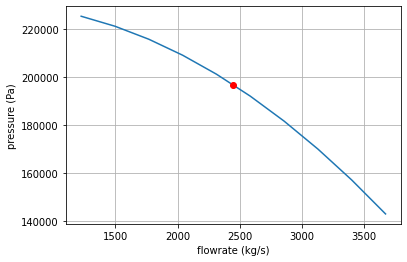

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(w_values, P_values)
ax.plot(wB, PB, "or")

ax.set(xlabel='flowrate (kg/s)', ylabel='pressure (Pa)',
       title='')
ax.grid()
plt.show()

## Final Simulation

In [29]:
data4 = data2.copy()
data4["condenser"]["states"]['stnFouling'] = "Dynamic"
data4["node_B"]["module"]="models.pumped_source2"
data4["node_B"]["class"]="PumpedSource"
data4["node_B"]["specifications"]={}
data4["node_B"]["states"]={"stnPump": 'Dynamic'}
data4["node_B"]["parameters"]["w0"]=wB
data4["node_B"]["parameters"]["a0"]=c[0]
data4["node_B"]["parameters"]["a1"]=c[1]
data4["node_B"]["parameters"]["a2"]=c[2]
with open("{}_{}_pumped.json".format(filename,suffix), 'w') as outfile:
    json.dump(data4, outfile, indent=4)

In [30]:
simulate.main(
    name=filename,
    input="{}_{}_pumped.json".format(filename,suffix),
    output="{}_{}_pumped.out.json".format(filename,suffix),
    initial_condition="{}_{}.out.json".format(filename, suffix),
    #init="{}_{}.out.json.init".format(filename, suffix),
    reporting_interval=10*24*3600,
    time_horizon=1000*24*3600,
    relative_tolerance=1e-3,
    MaxStep=10*24*3600,
    MaxNumSteps=100,
)

Creating the system...        
The system created successfully.
 0.00% ETA: [00.0s]Starting the initialization of the system... Done.
 0.00% ETA: [00.0s]Saving Initialization Values
Integrating from [0] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [0.010000000019176] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [10] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [864000] to [1728000] ...
 1.00% ETA:  25.6s]Integrating from [1728000] to [2592000] ...
 2.00% ETA:  32.5s]Integrating from [2592000] to [3456000] ...
 3.00% ETA:  38.8s]Integrating from [3456000] to [4320000] ...
 4.00% ETA:  12.0s]Integrating from [4320000] to [5184000] ...
 5.00% ETA:  20.3s]Integrating from [5184000] to [6048000] ...
 6.00% ETA:  45.5s]Integrating from [6048000] to [6912000] ...
 7.00% ETA:  20.7s]Integrating from [6912000] to [7776000] ...
 8.00% ETA:  02.1s]Integrating from [7776000] to [8640000] ...
 9.00% ETA:  47.6s]Integrating from [8640000] to [9504000] ...
 10.00% ETA:  36.0s]Int

 100.00% ETA: [00.0s]  Error test fails                  -              -        1
  Residuals (DAE)                   -              -      144
 100.00% ETA: [00.0s]  Residuals (total)             0.637           6.62      161
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Non-linear solver [Sundials modified Newton]:
 100.00% ETA: [00.0s]  Iterations                        -              -      142
 100.00% ETA: [00.0s]  Conv. fails                       -              -        0
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Linear solver [Sundials LU]:  
 100.00% ETA: [00.0s]  Setup                         0.000           0.00        0
 100.00% ETA: [00.0s]  Jacobian                      0.539           5.61       23
 100.00% ETA: [00.0s]  Solve                         0.000           0.00        0
 100.00% ETA: [00.0s]  Total LA                      0.000           0

In [31]:
with open("{}_{}_pumped.out.json".format(filename,suffix)) as f:
    json_data=f.read()
output = json.loads(json_data)

In [32]:
data4_s = data4.copy()

data4_s["node_B"] = {
    "kind": "node",
    "module": "models.river_pumped_source2",
    "class": "RiverPumpedSource",
    "states": {"stnPump": 'Dynamic'},
    "steady_state": True,
    "specifications": {
    },
    "parameters": {
        "Text0": Tin,
        "Pext": Pin,
        "w0": wB,
        "x": 0.0,
        "y": 0.0,
        "z": 0.0,
        "alpha1": Tin,
        "alpha2": 4,
        "tau": 0,
        "a0": c[0],
        "a1": c[1],
        "a2": c[2],
                
    },
    "initial_guess": {
        "w": m,
        "P": Pin,
        "T": Tin
    }
}
with open("{}_{}_pumped_season.json".format(filename, suffix), 'w') as outfile:
    json.dump(data4_s, outfile, indent=4)


In [33]:
simulate.main(
    name=filename,
    input="{}_{}_pumped_season.json".format(filename, suffix),
    output="{}_{}_pumped_season.out.json".format(filename, suffix),
    initial_condition="{}_{}.out.json".format(filename, suffix),
    #init="{}_{}.out.json.init".format(filename, suffix),
    reporting_interval=10*24*3600,
    time_horizon=1000*24*3600,
    relative_tolerance=1e-3,
    MaxStep=10*24*3600,
    MaxNumSteps=100,
)

Creating the system...        
The system created successfully.
 0.00% ETA: [00.0s]Starting the initialization of the system... Done.
 0.00% ETA: [00.0s]Saving Initialization Values
Integrating from [0] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [0.010000000019176] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [10] to [864000] ...
 0.00% ETA: [00.0s]Integrating from [864000] to [1728000] ...
 1.00% ETA:  58.7s]Integrating from [1728000] to [2592000] ...
 2.00% ETA:  27.3s]Integrating from [2592000] to [3456000] ...
 3.00% ETA:  53.8s]Integrating from [3456000] to [4320000] ...
 4.00% ETA:  23.5s]Integrating from [4320000] to [5184000] ...
 5.00% ETA:  29.1s]Integrating from [5184000] to [6048000] ...
 6.00% ETA:  52.8s]Integrating from [6048000] to [6912000] ...
 7.00% ETA:  26.8s]Integrating from [6912000] to [7776000] ...
 8.00% ETA:  07.7s]Integrating from [7776000] to [8640000] ...
 9.00% ETA:  52.5s]Integrating from [8640000] to [9504000] ...
 10.00% ETA:  40.4s]Int

 100.00% ETA: [00.0s]  Error test fails                  -              -        1
  Residuals (DAE)                   -              -      145
 100.00% ETA: [00.0s]  Residuals (total)             0.675           6.63      164
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Non-linear solver [Sundials modified Newton]:
 100.00% ETA: [00.0s]  Iterations                        -              -      143
 100.00% ETA: [00.0s]  Conv. fails                       -              -        0
 100.00% ETA: [00.0s]--------------------------------------------------------------
 100.00% ETA: [00.0s]Linear solver [Sundials LU]:  
 100.00% ETA: [00.0s]  Setup                         0.000           0.00        0
 100.00% ETA: [00.0s]  Jacobian                      0.529           5.20       22
 100.00% ETA: [00.0s]  Solve                         0.000           0.00        0
 100.00% ETA: [00.0s]  Total LA                      0.000           0